# OpenPIV masking tutorial


In this tutorial we focus on the two ways you can use image masking in OpenPIV. 

**Definitions**:

1. _static mask_ - an image with regions that should not be processed are marked as 1 (white color in black and white image or True) and regions that are processed are unmasked (zeros, False)

2. _dynamic mask_ - every pair of images (frame A, B) are processed to find out the region that has to be masked, e.g. a fish body around which we want to analyze PIV vectors. An average mask is then applied to both frames and PIV analysis 


OpenPIV uses these masks in two ways: 

1. masked image regions are set to zero or completely black. `frame_a[image_mask] = 0`
2. PIV analysis in a completely black interrogation windows result in a zero peak and marked as invalid. 
3. in addition, the image mask is converted in a set of `x,y` coordinates on a PIV grid that mark the masked region in the vector field. These `mask_coords` are propagating through the window deformation and stored with the `x,y,u,v,mask` in the ASCII result files. The vector fields `u,v` are `numpy.MaskedArray` so the masked regions are invalid and should not appear in the plot. They could be also replaced by zeros or `NaN` if needed. 

In [18]:
from openpiv import tools, pyprocess, validation, filters, scaling, preprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import importlib_resources
import pathlib

In [19]:
path = importlib_resources.files('openpiv') # pathlib.Path type

In [20]:
frame_a  = tools.imread( path / 'data' / 'test3' / 'pair_4_frame_0.jpg' )
frame_b  = tools.imread( path / 'data' / 'test3' / 'pair_4_frame_1.jpg' )

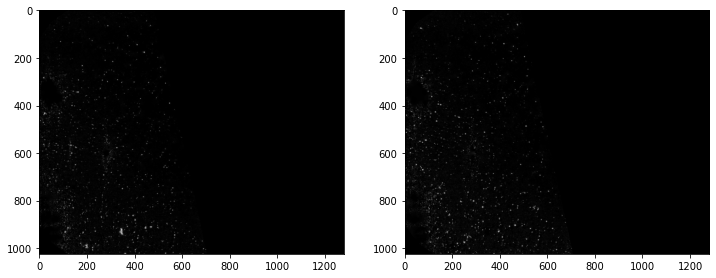

In [21]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap='gray');
ax[1].imshow(frame_b,cmap='gray');

## Rescale intensity or stretch histogram to get better contrast

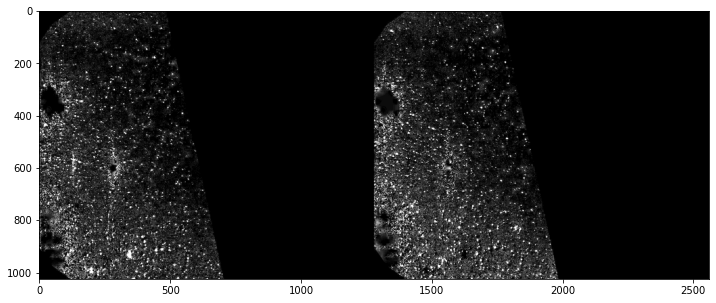

In [22]:
frame_a = preprocess.contrast_stretch(frame_a)
frame_b = preprocess.contrast_stretch(frame_b)
plt.figure(figsize=(12,12))
plt.imshow(np.c_[frame_a, frame_b], cmap='gray')

### Processing

In this tutorial, we are going to use the `extended_search_area_piv` function, wich is a standard PIV cross-correlation algorithm.

This function allows the search area (`search_area_size`) in the second frame to be larger than the interrogation window in the first frame (`window_size`). Also, the search areas can overlap (`overlap`).


The `extended_search_area_piv` function will return three arrays.
1. The `u` component of the velocity vectors
2. The `v` component of the velocity vectors
3. The signal-to-noise ratio (S2N) of the cross-correlation map of each vector. The higher the S2N of a vector, the higher the probability that its magnitude and direction are correct.

In [23]:
winsize = 64 # pixels, interrogation window size in frame A
searchsize = 64  # pixels, search area size in frame B
overlap = 32 # pixels, 50% overlap
dt = 1.0 # sec, time interval between the two frames

u, v, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32), 
    frame_b.astype(np.int32), 
    window_size=winsize, 
    overlap=overlap, 
    dt=dt, 
    search_area_size=searchsize, 
    sig2noise_method='peak2peak',
)

The function `get_coordinates` finds the center of each interrogation window. This will be useful later on when plotting the vector field.

In [24]:
x, y = pyprocess.get_coordinates( 
    image_size=frame_a.shape, 
    search_area_size=searchsize, 
    overlap=overlap,
)

### Post-processing

Strictly speaking, we are ready to plot the vector field. But before we do that, we can perform some convenient pos-processing.

To start, lets use the function `sig2noise_val` to get a mask indicating which vectors have a minimum amount of S2N. Vectors below a certain threshold are substituted by `NaN`. If you are not sure about which threshold value to use, try taking a look at the S2N histogram with:

`plt.hist(sig2noise.flatten())`

In [25]:
flags = validation.sig2noise_val( 
    sig2noise, 
    threshold = 1.0
)

Another useful function is `replace_outliers`, which will find outlier vectors, and substitute them by an average of neighboring vectors. The larger the `kernel_size` the larger is the considered neighborhood. This function uses an iterative image inpainting algorithm. The amount of iterations can be chosen via `max_iter`.

In [26]:
u, v = filters.replace_outliers( 
    u, v,
    flags,
    method='localmean', 
    max_iter=10, 
    kernel_size=2,
)

Next, we are going to convert pixels to millimeters, and flip the coordinate system such that the origin becomes the bottom left corner of the image.

In [27]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u, v = scaling.uniform(
    x, y, u, v, 
    scaling_factor = 96.52,  # 96.52 pixels/millimeter
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u, v = tools.transform_coordinates(x, y, u, v)

### Results

The function `save` is used to save the vector field to a ASCII tabular file. The coordinates and S2N mask are also saved.

In [28]:
# tools.save(filename, x,y,u,v, image_grid_mask, invalid_flag)
tools.save('exp1_001.txt', x, y, u, v, None, flags)

Finally, the vector field can be plotted with `display_vector_field`. 

Vectors with S2N bellow the threshold are displayed in red.

 Loading exp1_001.txt which exists True


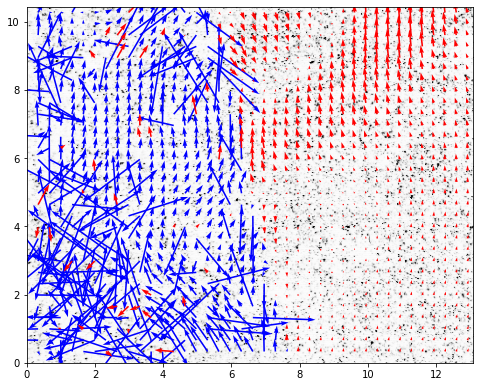

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(
    pathlib.Path('exp1_001.txt'), 
    ax=ax, scaling_factor=96.52, 
    scale=2, # scale defines here the arrow length
    width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= str(path / 'data'/'test1'/'exp1_001_a.bmp'),
);


## If we do not want to show the invalid vectors

set `show_invalid = False`

 Loading exp1_001.txt which exists True


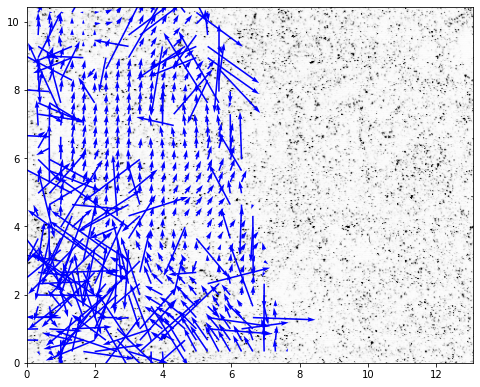

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(
    pathlib.Path('exp1_001.txt'), 
    ax=ax, scaling_factor=96.52, 
    scale=2, # scale defines here the arrow length
    width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= str(path / 'data'/'test1'/'exp1_001_a.bmp'),
    show_invalid=False,
);

## Tutorial on how to create a polygon mask

### Start with drawing a polygon, use image coordinates

**Important** if the polygon touches borders, leave 5 pixels at least from the border 

([500, 5], [700, 1019], [1275, 1019], [1275, 5])


(-0.5, 1279.5, 1023.5, -0.5)

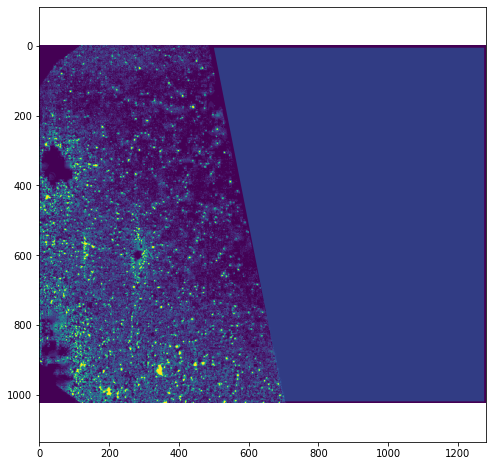

In [31]:

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(8,8))


ax.imshow(frame_a)

mask_coords = (
    [500,5],
    [700,frame_a.shape[0]-5],
    [frame_a.shape[1]-5,frame_a.shape[0]-5],
    [frame_a.shape[1]-5,5]
    )
print(mask_coords)

polygons = [Polygon(mask_coords)];
p = PatchCollection(polygons, alpha=0.5)
ax.add_collection(p)
ax.axis('equal')

In [32]:
# Note that mask_coordins for polygon are in image coordinates
# and here we need the grid coordinates, so we exchange x,y 

grid_mask = preprocess.prepare_mask_on_grid(x, y, np.array(mask_coords)[:,::-1])

Now use the grid mask to create masked arrays, like in `windef.py`

In [33]:
masked_u = np.ma.masked_array(u, mask=grid_mask)
masked_v = np.ma.masked_array(v, mask=grid_mask)


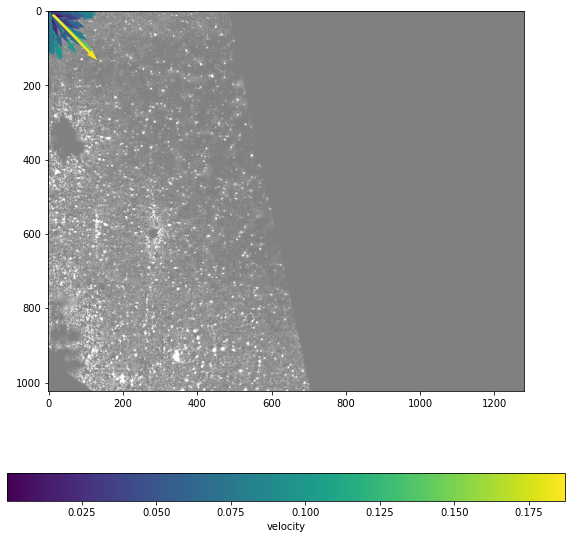

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(frame_a, alpha=.5,cmap='gray')
Q = ax.quiver(x,y,masked_u, masked_v, masked_u**2+masked_v**2, scale=3, width=.005,)
cb = fig.colorbar(Q,orientation='horizontal')
cb.set_label('velocity')